# Section average 
Global average or basin average, confidence interval using error propagation

In [2]:
%matplotlib inline
import numpy as np
import xarray as xr
import scipy.io as sio
import os
import matplotlib.pyplot as plt

In [3]:
def err_from_mean(var, var_err, var_eDOF, confidence_level=0.95):
    """assume all variables are independent, 
    can use error propagation to compute the error of the mean,
    given error of each variables
    
    eDOF = sum(eDOF)
    
    var: (LL_st, z_N2) or (z_N2)
    """
    
    import scipy.stats
    
    if len(var.shape) == 2:
        var_mean_ = np.zeros(len(var[0,:]),) + np.nan
        var_err_ = np.zeros(len(var[0,:]),) + np.nan
        var_CI_ = np.zeros((len(var[0,:]),2)) + np.nan
        for i in range(len(var[0,:])):
            idx_good = (~np.isnan(var_err[:,i])) & (~np.isinf(var_err[:,i]))
            if len(var_err[idx_good,i])>0:
                var_mean_[i] = np.mean(var[idx_good,i])
                var_err_[i] = np.sqrt(np.sum(var_err[idx_good,i]**2))/len(var_err[idx_good,i])
                var_CI_[i,:] = scipy.stats.t.interval(confidence_level, np.sum(var_eDOF[idx_good,i]), var_mean_[i], var_err_[i]) 
    else:
        idx_good = (~np.isnan(var_err)) & (~np.isinf(var_err))
        if len(var_err[idx_good])>0:
            var_mean_ = np.mean(var[idx_good])
            var_err_ = np.sqrt(np.sum(var_err[idx_good]**2))/len(var_err[idx_good])
            var_CI_ = scipy.stats.t.interval(confidence_level, np.sum(var_eDOF[idx_good]), var_mean_, var_err_) 
        else:
            var_mean_ = np.nan
            var_err_ = np.nan
            var_CI_ = np.array([np.nan, np.nan])
                
    return var_mean_, var_err_, var_CI_

In [4]:
def Basin_data(datafilepath, section_name, section_loc, method, data_name, var_name):
    """method = 1: lon section
       method = 0, lat section """
    from scipy.interpolate import interp1d
    
    count = 0
    for i in range(len(section_name)):
        acquisition = section_name[i]
        try:
            count += 1
            Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_" + data_name + ".nc")
            if count == 1:
                var = eval("Data_trend."+var_name+"_mean.data")
                var_err = eval("Data_trend."+var_name+"_err.data")
                var_eDOF = eval("Data_trend.eDOF.data")
                if method[i]:
                    var_lat = Data_trend.LL_st.data
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lon = f(var_lat)
                else:
                    var_lon = Data_trend.LL_st.data
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lat = f(var_lon)

            else:
                var = np.vstack((eval("Data_trend."+var_name+"_mean.data"), var))
                var_err = np.vstack((eval("Data_trend."+var_name+"_err.data"), var_err))
                var_eDOF = np.vstack((eval("Data_trend.eDOF.data"), var_eDOF))
                if method[i]:
                    var_lat = np.hstack((Data_trend.LL_st.data, var_lat))
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lon = np.hstack((f(Data_trend.LL_st.data), var_lon))
                else:
                    var_lon = np.hstack((Data_trend.LL_st.data, var_lon))
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lat = np.hstack((f(Data_trend.LL_st.data), var_lat))
        except FileNotFoundError:
            pass
    
    var_lon[var_lon<0]+=360
            
    return var, var_err, var_eDOF, var_lat, var_lon


In [5]:
def mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method, qc=0, confidence_level=0.95):
    """qc = 1: get rid of ratio > 50%"""
    if qc:
        if method == 1:
            var0 = var[idx_basin, :][:, idx_range].flatten()/N2_z_[idx_basin, :][:, idx_range].flatten()
            var__, var_err__, var_CI__ = err_from_mean(var0[np.abs(var0)<.5],
                                                   (var_err[idx_basin, :][:, idx_range].flatten()/N2_z_[idx_basin, :][:, idx_range].flatten())[np.abs(var0)<.5],
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten()[np.abs(var0)<.5], confidence_level)
        elif method == 2:
            var_, var_err_, var_CI_ = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                                                   var_err[idx_basin, :][:, idx_range].flatten(),
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level)
            var__ = var_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
            var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
            var_CI__ = var_CI_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
        elif method == 3:
            var0 = (var[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten()
            var__, var_err__, var_CI__ = err_from_mean(var0[np.abs(var0)<.5],
                                                   (var_err[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten()[np.abs(var0)<.5],
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten()[np.abs(var0)<.5], confidence_level)
    else:        
        if method == 1:
            var__, var_err__, var_CI__ = err_from_mean(var[idx_basin, :][:, idx_range].flatten()/N2_z_[idx_basin, :][:, idx_range].flatten(),
                                                   var_err[idx_basin, :][:, idx_range].flatten()/N2_z_[idx_basin, :][:, idx_range].flatten(),
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level)     
        elif method == 2:
            var_, var_err_, var_CI_ = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                                                   var_err[idx_basin, :][:, idx_range].flatten(),
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level)
            var__ = var_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
            var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
            var_CI__ = var_CI_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
        elif method == 3:
            var__, var_err__, var_CI__ = err_from_mean((var[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
                                                   (var_err[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level)
    
    return var__, var_CI__



def mean_in_basin(var, var_err, var_eDOF, N2_z_, idx_basin, method, qc=0, confidence_level=0.95):
    """qc = 1: get rid of ratio > 50%"""
    if qc:
        if method == 1:
            var0 = var[idx_basin, :]/N2_z_[idx_basin, :]
            var0_err = var_err[idx_basin, :]/N2_z_[idx_basin, :]
            var0_eDOF = var_eDOF[idx_basin, :]
            if len(var0_err[np.abs(var0)>=.5])>0:
                var0_err[np.abs(var0)>=.5] = np.nan
                var0_eDOF[np.abs(var0)>=.5] = np.nan
                var0[np.abs(var0)>=.5] = np.nan  
            var__, var_err__, var_CI__ = err_from_mean(var0,
                                                   var0_err,
                                                   var0_eDOF, confidence_level)     
        elif method == 2:
            var_, var_err_, var_CI_ = err_from_mean(var[idx_basin, :],
                                                   var_err[idx_basin, :],
                                                   var_eDOF[idx_basin, :], confidence_level)
            var__ = var_/np.nanmean(N2_z_[idx_basin, :], axis=0)
            var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :], axis=0)
            var_CI__ = np.array([var_CI_[:,0]/np.nanmean(N2_z_[idx_basin, :], axis=0), var_CI_[:,1]/np.nanmean(N2_z_[idx_basin, :], axis=0)]).T                                                         
        elif method == 3:
            var0 = var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0)
            var0_err = var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0)
            var0_eDOF = var_eDOF[idx_basin, :]
            if len(var0_err[np.abs(var0)>=.5])>0:
                var0_err[np.abs(var0)>=.5] = np.nan
                var0_eDOF[np.abs(var0)>=.5] = np.nan
                var0[np.abs(var0)>=.5] = np.nan            
            var__, var_err__, var_CI__ = err_from_mean(var0,
                                                   var0_err,
                                                   var0_eDOF, confidence_level)     
    else:
        if method == 1:
            var__, var_err__, var_CI__ = err_from_mean(var[idx_basin, :]/N2_z_[idx_basin, :],
                                                   var_err[idx_basin, :]/N2_z_[idx_basin, :],
                                                   var_eDOF[idx_basin, :], confidence_level)     
        elif method == 2:
            var_, var_err_, var_CI_ = err_from_mean(var[idx_basin, :],
                                                   var_err[idx_basin, :],
                                                   var_eDOF[idx_basin, :], confidence_level)
            var__ = var_/np.nanmean(N2_z_[idx_basin, :], axis=0)
            var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :], axis=0)
            var_CI__ = np.array([var_CI_[:,0]/np.nanmean(N2_z_[idx_basin, :], axis=0), var_CI_[:,1]/np.nanmean(N2_z_[idx_basin, :], axis=0)]).T                                                         
        elif method == 3:
            var__, var_err__, var_CI__ = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),
                                                   var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),
                                                   var_eDOF[idx_basin, :], confidence_level)

        
    return var__, var_CI__

## Parameters

In [6]:
# path to WOCE read trend results
resultfilepath = '../results/'
datafilepath = '/Users/stan/Desktop/WORK/DATA/GOSHIP/EasyOcean/gridded/'
# path to saved data
outfilepath = '../figure/'

param_plot = {"z1_up": 2000,
              "z2_up": 0,
              "z1_lw": 6000,
              "z2_lw": 2000,
              "sig1_up": 45.65,
              "sig2_up": 43,
              "sig1_lw": 46.25,
              "sig2_lw": 45.95,
              "vlim1": [-1e-7,1e-7],
              "vlim2": [-1e-7,1e-7],
              "vlim_factor1": [.8,1.2],
              "vlim_factor2": [.8,1.2],
            }

# location info
import pickle
loc_info = open(resultfilepath + 'EasyOcean_location.obj', 'rb')
loc = pickle.load(loc_info)
loc_info.close()

# default way to compute confidence interval of factors
method_mean = 3

In [7]:
section_name = loc["lon_sec"] + loc["lat_sec"]
# section_loc = np.hstack((loc['loc_lon_sec'], loc['loc_lat_sec']))
section_loc = [*loc["loc_lon_all"], *loc["loc_lat_all"]]
method = np.hstack((np.ones(loc['loc_lon_sec'].shape), np.zeros(loc['loc_lat_sec'].shape))).astype('bool')
var, var_err, var_eDOF, var_lat, var_lon = Basin_data(
    datafilepath,
    section_name, 
    section_loc, 
    method, 
    "trend", 
    "trend_N2")
z_thred = [2000, 4000]

In [8]:
# ALL N2 change in one dataset, z-coordinate
count = 0
for i in range(len(section_name)):
    acquisition = section_name[i]
    try:
        count += 1
        Data_block = xr.open_dataset(datafilepath + acquisition.lower() + "_block.nc")
        if count == 1:
            N2_z_ = Data_block.N2_mean[0,:,:].data
        else:
            N2_z_ = np.vstack((Data_block.N2_mean[0,:,:].data, N2_z_))

    except FileNotFoundError:
        pass


count = 0
for i in range(len(section_name)):
    acquisition = section_name[i]
    try:
        count += 1
        Data_block = xr.open_dataset(datafilepath + acquisition.lower() + "_block.nc")
        if count == 1:
            N2_z__ = Data_block.N2_mean.mean(axis=0, skipna=True).data
        else:
            N2_z__ = np.vstack((Data_block.N2_mean.mean(axis=0, skipna=True).data, N2_z__))

    except FileNotFoundError:
        pass

z_N2 = Data_block.z_N2.data    
N2_z_.shape, N2_z__.shape, var.shape

((588, 17), (588, 17), (588, 17))

## Main Program

### 1. South of 60S, SH, NH

----------south of 60$^{\circ}$S----------
max N2 : -4.4758716884658084e-08 (-5.823466507376466e-08,-3.128276869555151e-08) at 4800 m
mean 2000 m $\leq z \leq$4000 m: -3.4% (-3.8%,-3.0%)
mean 2000 m $\leq z \leq$4000 m:,  -1.5422013938392086e-08, (-1.7317047917805704e-08,-1.3526979958978469e-08)
mean $z\geq$4000 m: -6.3% (-10.6%,-2.0%)
mean $z\geq$4000 m:,  -2.1151205417026065e-08, (-3.469820234486617e-08,-7.604208489185955e-09)
max N2 factor change:-15.2%(-19.8%,-10.6%) at 4800 m
----------Southern Hemisphere----------
max N2 : -2.7737562076633505e-08 (-8.576862771097237e-08,3.0293503557705356e-08) at 6400 m
mean 2000 m $\leq z \leq$4000 m: -0.5% (-0.8%,-0.1%)
mean 2000 m $\leq z \leq$4000 m:,  -2.1879796143858455e-09, (-5.26744615442167e-09,8.914869256499787e-10)
mean $z\geq$4000 m: -3.1% (-6.2%,-0.0%)
mean $z\geq$4000 m:,  -9.539084964299329e-09, (-1.5945330147807856e-08,-3.1328397807908032e-09)
max N2 factor change:-67.5%(-208.9%,73.8%) at 6400 m
----------Northern Hemisphere------

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:34: RuntimeWarning: Mean of empty slice
  var__, var_err__, var_CI__ = err_from_mean((var[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:35: RuntimeWarning: Mean of empty slice
  (var_err[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:87: RuntimeWarning: Mean of empty slice
  var__, var_err__, var_CI__ = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:88: RuntimeWarning: Mean of empty slice
  var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScr

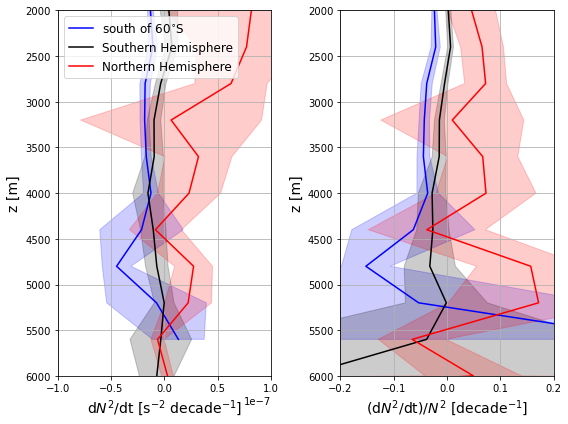

In [9]:
lat_st = [-90, -90, 0]
lat_ed = [-60, 0, 90]
colors = ['b', 'k', 'r']
labels = ['south of 60$^{\circ}$S', 'Southern Hemisphere', 'Northern Hemisphere']
section_name = loc["lon_sec"] + loc["lat_sec"]
section_loc = [*loc["loc_lon_all"], *loc["loc_lat_all"]]
method = np.hstack((np.ones(loc['loc_lon_sec'].shape), np.zeros(loc['loc_lat_sec'].shape))).astype('bool')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,6), sharey=False, sharex=False)
for i in range(len(lat_st)):
    print(10*'-'+labels[i]+10*'-')
    lat_range = [lat_st[i], lat_ed[i]]
    idx_basin = (var_lat>=lat_range[0]) & (var_lat<=lat_range[1])
    N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :], var_err[idx_basin, :], var_eDOF[idx_basin, :])
    ax[0].plot(N2_trend_z, z_N2, color=colors[i], label=labels[i])
    ax[0].fill_betweenx(z_N2, 
                     N2_trend_CI_z[:,0],
                     N2_trend_CI_z[:,1],
                     color=colors[i], alpha=.2)  
    ax[0].set_ylim([param_plot['z1_lw'], param_plot['z1_up']])
    ax[0].set_xlim(param_plot['vlim1'])
    ax[0].grid(True)
    ax[0].set_ylabel('z [m]', fontsize=14)
    ax[0].set_xlabel('d$N^2$/dt [s$^{-2}$ decade$^{-1}$]', fontsize=14)
    ax[0].legend(fontsize=12)
    idx = np.where(N2_trend_z[z_N2>=z_thred[0]]==np.nanmin(N2_trend_z[z_N2>=z_thred[0]]))[0][0]
    print(f"max N2 : {(np.nanmin(N2_trend_z[z_N2>=z_thred[0]]))} ({N2_trend_CI_z[z_N2>=z_thred[0],0][idx]},{N2_trend_CI_z[z_N2>=z_thred[0],1][idx]}) at {z_N2[z_N2>=z_thred[0]][idx]} m")

    for k in range(len(z_thred)):
        if k == 1:
            idx_range = (z_N2>=z_thred[1])
        elif k == 0: 
            idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])

        # factor change
        var_, var_CI_ = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean)
        if k == 1:
            print(f'mean $z\geq${z_thred[k]} m:',  "{:.1%}".format(var_), '('+"{:.1%}".format(var_CI_[0])+','+"{:.1%}".format(var_CI_[1])+')')
        elif k == 0:
            print(f'mean {z_thred[0]} m $\leq z \leq${z_thred[1]} m:',  "{:.1%}".format(var_), '('+"{:.1%}".format(var_CI_[0])+','+"{:.1%}".format(var_CI_[1])+')')

        # absolute change
        var_, var_err_, var_CI_ = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                                   var_err[idx_basin, :][:, idx_range].flatten(),
                                   var_eDOF[idx_basin, :][:, idx_range].flatten())
        if k == 1:
            print(f'mean $z\geq${z_thred[k]} m:,  {var_}, ({var_CI_[0]},{var_CI_[1]})')
        elif k == 0:
            print(f'mean {z_thred[0]} m $\leq z \leq${z_thred[1]} m:,  {var_}, ({var_CI_[0]},{var_CI_[1]})')

    
    var_, var_CI_ = mean_in_basin(var, var_err, var_eDOF, N2_z_, idx_basin, method_mean)
    print(f"max N2 factor change:"+ "{:.1%}".format(var_[z_N2>=z_thred[0]][idx])+ "("+"{:.1%}".format(var_CI_[z_N2>=z_thred[0],0][idx])+','+"{:.1%}".format(var_CI_[z_N2>=z_thred[0],1][idx]) + f") at {z_N2[z_N2>=z_thred[0]][idx]} m")
    ax[1].plot(var_, z_N2, color=colors[i])
    ax[1].fill_betweenx(z_N2, 
                     var_CI_[:,0],
                     var_CI_[:,1],
                     color=colors[i], alpha=.2)  
    ax[1].set_ylim([param_plot['z1_lw'], param_plot['z1_up']])
    ax[1].set_xlim([-.2, .2])
    ax[1].grid(True)
    ax[1].set_ylabel('z [m]', fontsize=14)
    ax[1].set_xlabel('(d$N^2$/dt)/$N^2$ [decade$^{-1}$]', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath + f'Global_mean_N2trend_z.jpeg', dpi=300)
plt.savefig(outfilepath + f'Global_mean_N2trend_z.eps')

In [10]:
i = 0
lat_range = [lat_st[i], lat_ed[i]]
idx_basin = (var_lat>=lat_range[0]) & (var_lat<=lat_range[1])
N2_trend_z_sh, N2_trend_err_z_sh, N2_trend_CI_z_sh = err_from_mean(var[idx_basin, :], var_err[idx_basin, :], var_eDOF[idx_basin, :])
N2_trend_z_sh_percentage, N2_trend_CI_z_sh_percentage = mean_in_basin(var, var_err, var_eDOF, N2_z_, idx_basin, method_mean)


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:87: RuntimeWarning: Mean of empty slice
  var__, var_err__, var_CI__ = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:88: RuntimeWarning: Mean of empty slice
  var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),


### 2. Each basin

In [11]:
def within_basin(var_lon, var_lat, k):
    """input an arry of lon and lat, output mask for the kth basin in the basin boundary data from Purkey and Johnson (2010)
    https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask
    """
    
    basin = sio.loadmat('../data/bsn_boundary.mat', squeeze_me=True, struct_as_record=False)

    keys = {0: ['GB', 'Guatemala basin'],
    1: ['', ''],
    2: ['PER', 'Peru basin'],
    3: ['CHI', 'Chile basin'], 
    4: ['SWP', 'Southwest Pacific basin'], 
    5: ['', ''],
    6: ['ABB', 'Amundsen‐Bellingshausen basin'],
    7: ['CS', 'Coral Sea'], 
    8: ['PB', 'Pacific basin'], 
    9: ['TAS', 'Tasman Sea'],
    10: ['SB', 'Somali basin'],
    11: ['SAB', 'South Australian basin'], 
    12: ['OS', 'Okhotsk Sea'],
    13: ['BS', 'Bering Sea'],
    14: ['ARG', 'Argentine basin'],
    15: ['BB', 'Brazil basin'],
    16: ['', ''],
    17: ['NAB', 'North Atlantic basin'],
    18: ['AGU', 'Agulhas–Mozambique basin'],
    19: ['ANG', 'Angola basin'],
    20: ['IB', 'Iberian/Canary/Cape Verde basin'], 
    21: ['AS', 'Arabian Sea'],
    22: ['WEB', 'Weddell–Enderby basin'],
    23: ['CAP', 'Cape basin'], 
    24: ['', ''],
    25: ['SS', 'Scotia Sea'], 
    26: ['MB', 'Madagascar basin'], 
    27: ['MIB', 'mid-Indian basin'], 
    28: ['WB', 'Wharton basin'], 
    29: ['CRO', 'Crozet basin'], 
    30: ['AAB', 'Australian-Antarctic basin'], 
    31: ['PHI', 'Philippine basin'], 
    32: ['ECS', 'east of Coral Sea'], }
    
    var_lon_ = var_lon.copy()
    var_lat_ = var_lat.copy()
    
    from matplotlib.path import Path
    for i in range(len(basin['bsn_only'][k].bsn[0])):
        if i == 0:
            basin_verts = [(basin['bsn_only'][k].bsn[0][i], basin['bsn_only'][k].bsn[1][i])]
        else:
            basin_verts.append((basin['bsn_only'][k].bsn[0][i], basin['bsn_only'][k].bsn[1][i]))
    basin_path = Path(basin_verts)
    if k == 19 | k == 23:
        var_lon_[var_lon_<basin['bsn_only'][k].bsn[0].max() - 360]+=360
    if k == 22:
        var_lon_[var_lon_>basin['bsn_only'][k].bsn[0].min() + 360]-=360
        
    var_mask = basin_path.contains_points(np.vstack((var_lon_,var_lat_)).T)
    
    return var_mask, keys

In [12]:
idx_ = np.array(([26, 27, 28, 8, 2, 3, 15, 19, 23], [29, 11, 30, np.nan, 4, 6, 14, 22, 18]))
idx__ = idx_.flatten()
bas_names = []
    
N2_trend = np.zeros((len(idx__), len(z_thred)))
N2_trend_CI_95 = np.zeros((len(idx__), len(z_thred), 2))
N2_trend_CI_85 = np.zeros((len(idx__), len(z_thred), 2))
N2_trend_CI_68 = np.zeros((len(idx__), len(z_thred), 2))

N2_trend_percentage = np.zeros((len(idx__), len(z_thred), 3))
N2_trend_percentage_CI_95 = np.zeros((len(idx__), len(z_thred), 3, 2))
N2_trend_percentage_CI_85 = np.zeros((len(idx__), len(z_thred), 3, 2))
N2_trend_percentage_CI_68 = np.zeros((len(idx__), len(z_thred), 3, 2))

for idx in range(len(idx__)):
    if np.isnan(idx__[idx]):        
        idx_basin1, _ = within_basin(var_lon, var_lat, 9)
        idx_basin2, _ = within_basin(var_lon, var_lat, 7)
        idx_basin3, _ = within_basin(var_lon, var_lat, 32)
        idx_basin = (idx_basin1) | (idx_basin2) | (idx_basin3)
        bas_names += ['TS+CS+ECS']
    else:
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx__[idx]))
        bas_names += [var_keys[idx__[idx]][0]]
        
    for k in range(len(z_thred)):
        if k == 1:
            idx_range = (z_N2>=z_thred[1])
        elif k == 0: 
            idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
        for method_mean in [1, 2, 3]:    
            N2_trend_percentage[idx,k,method_mean-1], N2_trend_percentage_CI_95[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean)       
            _, N2_trend_percentage_CI_85[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean, confidence_level=.85)
            _, N2_trend_percentage_CI_68[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean, confidence_level=.68)

        N2_trend[idx,k], _, N2_trend_CI_95[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten())
        _, _, N2_trend_CI_85[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level=.85)
        _, _, N2_trend_CI_68[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level=.68)


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:34: RuntimeWarning: Mean of empty slice
  var__, var_err__, var_CI__ = err_from_mean((var[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:35: RuntimeWarning: Mean of empty slice
  (var_err[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),


In [13]:
N2_trend_basin= xr.Dataset({'N2_trend': (['basin_names', 'z_thred'], N2_trend),
                            'N2_trend_CI_95': (['basin_names', 'z_thred', 'limits'], N2_trend_CI_95),
                            'N2_trend_CI_85': (['basin_names', 'z_thred', 'limits'], N2_trend_CI_85),
                            'N2_trend_CI_68': (['basin_names', 'z_thred', 'limits'], N2_trend_CI_68),
                            'N2_trend_percentage': (['basin_names', 'z_thred', 'method_mean'], N2_trend_percentage),
                            'N2_trend_percentage_CI_95': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_percentage_CI_95),
                            'N2_trend_percentage_CI_85': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_percentage_CI_85),
                            'N2_trend_percentage_CI_68': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_percentage_CI_68),
                            },
                      coords={'basin_names': bas_names, 
                              'basin_idx': idx__, 
                              'z_thred': z_thred, 
                              'method_mean': np.array([1,2,3]),
                              'limits': np.array([0,1])},
                      attrs={'title': 'N2 change averaged in basins'})
N2_trend_basin.to_netcdf(resultfilepath+'N2_trend_basin_z.nc')

In [14]:
N2_trend_basin.N2_trend_percentage[:,:,-1].sel(basin_names='AAB'), N2_trend_basin.N2_trend_percentage[:,:,-1].sel(basin_names='ABB'), N2_trend_basin.N2_trend_percentage[:,:,-1].sel(basin_names='WEB')

(<xarray.DataArray 'N2_trend_percentage' (z_thred: 2)>
 array([-0.02619991, -0.17336812])
 Coordinates:
     basin_names  <U9 'AAB'
   * z_thred      (z_thred) int64 2000 4000
     method_mean  int64 3,
 <xarray.DataArray 'N2_trend_percentage' (z_thred: 2)>
 array([-0.04551499, -0.08122399])
 Coordinates:
     basin_names  <U9 'ABB'
   * z_thred      (z_thred) int64 2000 4000
     method_mean  int64 3,
 <xarray.DataArray 'N2_trend_percentage' (z_thred: 2)>
 array([-0.00691581, -0.00378953])
 Coordinates:
     basin_names  <U9 'WEB'
   * z_thred      (z_thred) int64 2000 4000
     method_mean  int64 3)

In [15]:
N2_trend_basin.N2_trend_percentage_CI_95[:,:,-1,0].to_pandas()

z_thred,2000,4000
basin_names,,
MB,0.011164,-0.164570
MIB,-0.019929,-0.010712
WB,-0.042689,-0.322313
PB,-0.003844,-0.066604
PER,-0.015544,-0.280388
CHI,-0.005868,-0.685979
BB,-0.010785,-0.079049
ANG,0.011303,-0.071953
CAP,-0.030627,-0.084052


In [16]:
N2_trend_basin.N2_trend_percentage_CI_95[:,:,-1,1].to_pandas()

z_thred,2000,4000
basin_names,,
MB,0.031837,0.158510
MIB,0.009089,0.102362
WB,-0.007755,0.224989
PB,0.001806,0.025077
PER,0.001380,0.189623
CHI,0.008233,0.020255
BB,0.003623,0.066532
ANG,0.029965,0.042365
CAP,0.045594,0.033118


In [17]:
N2_trend_basin.N2_trend_percentage[:,:,-1].to_pandas()

z_thred,2000,4000
basin_names,,
MB,0.021500,-0.003030
MIB,-0.005420,0.045825
WB,-0.025222,-0.048662
PB,-0.001019,-0.020763
PER,-0.007082,-0.045383
CHI,0.001182,-0.332862
BB,-0.003581,-0.006259
ANG,0.020634,-0.014794
CAP,0.007484,-0.025467


In [18]:
idx_all = np.arange(len(var_keys))
N2_trend_all = np.zeros((len(idx_all), len(z_thred)))
N2_trend_all_CI_95 = np.zeros((len(idx_all), len(z_thred), 2))
N2_trend_all_CI_85 = np.zeros((len(idx_all), len(z_thred), 2))
N2_trend_all_CI_68 = np.zeros((len(idx_all), len(z_thred), 2))

N2_trend_all_percentage = np.zeros((len(idx_all), len(z_thred), 3))
N2_trend_all_percentage_CI_95 = np.zeros((len(idx_all), len(z_thred), 3, 2))
N2_trend_all_percentage_CI_85 = np.zeros((len(idx_all), len(z_thred), 3, 2))
N2_trend_all_percentage_CI_68 = np.zeros((len(idx_all), len(z_thred), 3, 2))

bas_names_all = []
for idx in range(len(var_keys)):
    bas_names_all += [var_keys[idx_all[idx]][0]]
    
for idx in range(len(idx_all)):
    if (idx_all[idx] == 9) | (idx_all[idx] == 7) | (idx_all[idx] == 32):
        idx_basin1, _ = within_basin(var_lon, var_lat, 9)
        idx_basin2, _ = within_basin(var_lon, var_lat, 7)
        idx_basin3, _ = within_basin(var_lon, var_lat, 32)
        idx_basin = (idx_basin1) | (idx_basin2) | (idx_basin3)
    else:
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx_all[idx]))
        
    for k in range(len(z_thred)):
        if k == 1:
            idx_range = (z_N2>=z_thred[1])
        elif k == 0: 
            idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
        for method_mean in [1, 2, 3]:    
            N2_trend_all_percentage[idx,k,method_mean-1], N2_trend_all_percentage_CI_95[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean)       
            _, N2_trend_all_percentage_CI_85[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean, confidence_level=.85)
            _, N2_trend_all_percentage_CI_68[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean, confidence_level=.68)

        N2_trend_all[idx,k], _, N2_trend_all_CI_95[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten())
        _, _, N2_trend_all_CI_85[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level=.85)
        _, _, N2_trend_all_CI_68[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level=.68)


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:30: RuntimeWarning: Mean of empty slice
  var__ = var_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:31: RuntimeWarning: Mean of empty slice
  var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:32: RuntimeWarning: Mean of empty slice
  var_CI__ = var_CI_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:34: RuntimeWarning: Mean of empty slice
  var__, var_err__, var_CI__ = err_from_mean((var[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3151260083.py:35: RuntimeWarning: Mean of empty slice
  (var_err[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range

In [19]:
N2_trend_basin_all= xr.Dataset({'N2_trend': (['basin_names', 'z_thred'], N2_trend_all),
                            'N2_trend_CI_95': (['basin_names', 'z_thred', 'limits'], N2_trend_all_CI_95),
                            'N2_trend_CI_85': (['basin_names', 'z_thred', 'limits'], N2_trend_all_CI_85),
                            'N2_trend_CI_68': (['basin_names', 'z_thred', 'limits'], N2_trend_all_CI_68),
                            'N2_trend_percentage': (['basin_names', 'z_thred', 'method_mean'], N2_trend_all_percentage),
                            'N2_trend_percentage_CI_95': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_all_percentage_CI_95),
                            'N2_trend_percentage_CI_85': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_all_percentage_CI_85),
                            'N2_trend_percentage_CI_68': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_all_percentage_CI_68),
                            },
                      coords={'basin_names': bas_names_all, 
                              'basin_idx': idx_all, 
                              'z_thred': z_thred, 
                              'method_mean': np.array([1,2,3]),
                              'limits': np.array([0,1])},
                      attrs={'title': 'N2 change averaged in basins'})
N2_trend_basin_all.to_netcdf(resultfilepath+'N2_trend_basin_z_all.nc')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

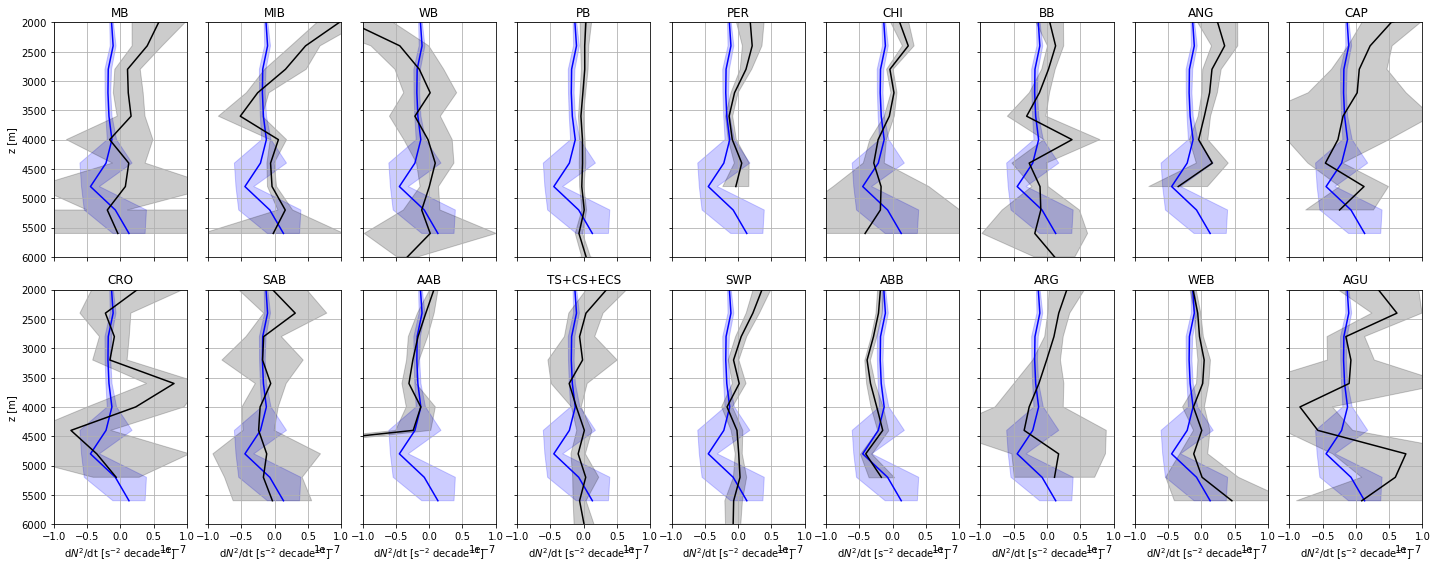

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(20, 8))
for idx in range(len(idx_[0])):
    if ~np.isnan(idx_[0,idx]):
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx_[0,idx]))
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :], var_err[idx_basin, :], var_eDOF[idx_basin, :])
        ax[0,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
        ax[0,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z_sh[:,0],
                         N2_trend_CI_z_sh[:,1],
                         color='b', alpha=.2)  
        ax[0,idx].plot(N2_trend_z, z_N2, color='k')
        ax[0,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[0,idx].set_ylim([param_plot['z1_lw'], param_plot['z1_up']])
        ax[0,idx].set_xlim(param_plot['vlim1'])
        ax[0,idx].grid(True)
        if idx == 0:
            ax[0,idx].set_ylabel('z [m]')
        if idx > 0:
            ax[0,idx].set_yticklabels([])
        ax[0,idx].set_xticklabels([])
        ax[0,idx].set_title(var_keys[idx_[0,idx]][0])
        
for idx in range(len(idx_[1])):
    if ~np.isnan(idx_[1,idx]):
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx_[1,idx]))
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :], var_err[idx_basin, :], var_eDOF[idx_basin, :])
        ax[1,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
        ax[1,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z_sh[:,0],
                         N2_trend_CI_z_sh[:,1],
                         color='b', alpha=.2)  
        ax[1,idx].plot(N2_trend_z, z_N2, color='k')
        ax[1,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[1,idx].set_ylim([param_plot['z1_lw'], param_plot['z1_up']])
        ax[1,idx].set_xlim(param_plot['vlim1'])
        ax[1,idx].grid(True)
        if idx == 0:
            ax[1,idx].set_ylabel('z [m]')
        if idx > 0:
            ax[1,idx].set_yticklabels([])
        ax[1,idx].set_title(var_keys[idx_[1,idx]][0])
        ax[1,idx].set_xlabel('d$N^2$/dt [s$^{-2}$ decade$^{-1}$]')
    else:
        idx_basin1, _ = within_basin(var_lon, var_lat, 9)
        idx_basin2, _ = within_basin(var_lon, var_lat, 7)
        idx_basin3, _ = within_basin(var_lon, var_lat, 32)
        idx_basin = (idx_basin1) | (idx_basin2) | (idx_basin3)
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :], var_err[idx_basin, :], var_eDOF[idx_basin, :])
        ax[1,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
        ax[1,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z_sh[:,0],
                         N2_trend_CI_z_sh[:,1],
                         color='b', alpha=.2)  
        ax[1,idx].plot(N2_trend_z, z_N2, color='k')
        ax[1,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[1,idx].set_ylim([param_plot['z1_lw'], param_plot['z1_up']])
        ax[1,idx].set_xlim(param_plot['vlim1'])
        ax[1,idx].grid(True)
        if idx == 0:
            ax[1,idx].set_ylabel('z [m]')
        if idx > 0:
            ax[1,idx].set_yticklabels([])
        ax[1,idx].set_title('TS+CS+ECS')
        ax[1,idx].set_xlabel('d$N^2$/dt [s$^{-2}$ decade$^{-1}$]')
        
plt.tight_layout()
plt.savefig(outfilepath+ 'selected_basins_N2trend_mean.jpeg', dpi=300)
plt.savefig(outfilepath+ 'selected_basins_N2trend_mean.eps')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3830329183.py:5: RuntimeWarning: Mean of empty slice
  N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3830329183.py:5: RuntimeWarning: Mean of empty slice
  N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/3830329183.py:5: RuntimeWarning: Mean of empty slice
  N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
/var/folders/sr/6_bkfhj929364hv72k5pf

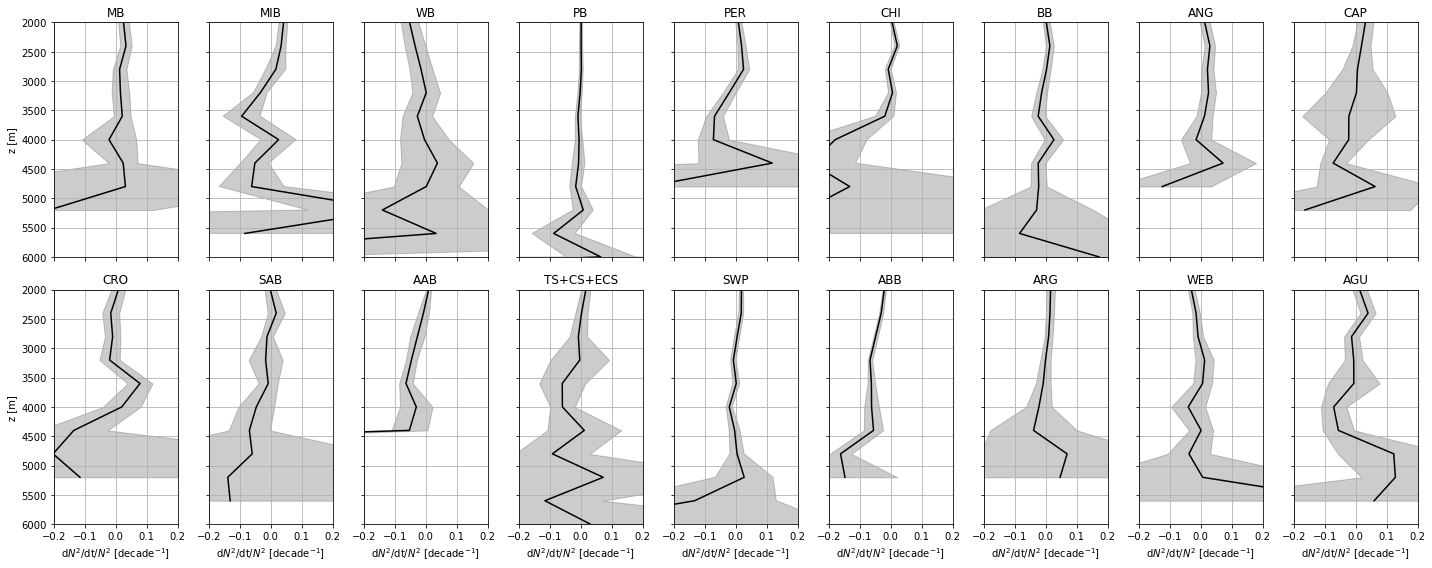

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(20, 8))
for idx in range(len(idx_[0])):
    if ~np.isnan(idx_[0,idx]):
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx_[0,idx]))
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
#         ax[0,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
#         ax[0,idx].fill_betweenx(z_N2, 
#                          N2_trend_CI_z_sh[:,0],
#                          N2_trend_CI_z_sh[:,1],
#                          color='b', alpha=.2)  
        ax[0,idx].plot(N2_trend_z, z_N2, color='k')
        ax[0,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[0,idx].set_ylim([param_plot['z1_lw'], param_plot['z1_up']])
        ax[0,idx].set_xlim([-.2, .2])
        ax[0,idx].grid(True)
        if idx == 0:
            ax[0,idx].set_ylabel('z [m]')
        if idx > 0:
            ax[0,idx].set_yticklabels([])
        ax[0,idx].set_xticklabels([])
        ax[0,idx].set_title(var_keys[idx_[0,idx]][0])
        
for idx in range(len(idx_[1])):
    if ~np.isnan(idx_[1,idx]):
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx_[1,idx]))
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
#         ax[1,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
#         ax[1,idx].fill_betweenx(z_N2, 
#                          N2_trend_CI_z_sh[:,0],
#                          N2_trend_CI_z_sh[:,1],
#                          color='b', alpha=.2)  
        ax[1,idx].plot(N2_trend_z, z_N2, color='k')
        ax[1,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[1,idx].set_ylim([param_plot['z1_lw'], param_plot['z1_up']])
        ax[1,idx].set_xlim([-.2, .2])
        ax[1,idx].grid(True)
        if idx == 0:
            ax[1,idx].set_ylabel('z [m]')
        if idx > 0:
            ax[1,idx].set_yticklabels([])
        ax[1,idx].set_title(var_keys[idx_[1,idx]][0])
        ax[1,idx].set_xlabel('d$N^2$/dt/$N^2$ [decade$^{-1}$]')
    else:
        idx_basin1, _ = within_basin(var_lon, var_lat, 9)
        idx_basin2, _ = within_basin(var_lon, var_lat, 7)
        idx_basin3, _ = within_basin(var_lon, var_lat, 32)
        idx_basin = (idx_basin1) | (idx_basin2) | (idx_basin3)
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
#         ax[1,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
#         ax[1,idx].fill_betweenx(z_N2, 
#                          N2_trend_CI_z_sh[:,0],
#                          N2_trend_CI_z_sh[:,1],
#                          color='b', alpha=.2)  
        ax[1,idx].plot(N2_trend_z, z_N2, color='k')
        ax[1,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[1,idx].set_ylim([param_plot['z1_lw'], param_plot['z1_up']])
        ax[1,idx].set_xlim([-.2, .2])
        ax[1,idx].grid(True)
        if idx == 0:
            ax[1,idx].set_ylabel('z [m]')
        if idx > 0:
            ax[1,idx].set_yticklabels([])
        ax[1,idx].set_title('TS+CS+ECS')
        ax[1,idx].set_xlabel('d$N^2$/dt/$N^2$ [decade$^{-1}$]')
        
plt.tight_layout()
plt.savefig(outfilepath+ 'selected_basins_N2trend_percentage.jpeg', dpi=300)
plt.savefig(outfilepath+ 'selected_basins_N2trend_percentage.eps')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/2973536531.py:4: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(N2_z_[idx_basin,:],0), z_N2, color='r', label=var_keys[idx][0])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/2973536531.py:7: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(N2_z_[idx_basin,:],0), z_N2, color='k', label=var_keys[idx][0])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/2973536531.py:14: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(N2_z_[idx_basin,:],0), z_N2, color='.5', label=var_keys[idx][0])


Text(0.5, 0, '$N^2$')

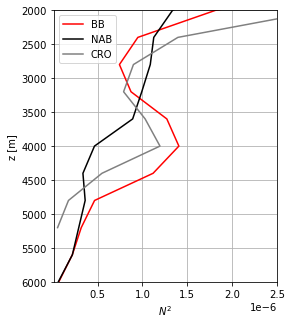

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))
idx = 15
idx_basin, var_keys = within_basin(var_lon, var_lat, idx)
ax.plot(np.nanmean(N2_z_[idx_basin,:],0), z_N2, color='r', label=var_keys[idx][0])
idx = 17
idx_basin, var_keys = within_basin(var_lon, var_lat, idx)
ax.plot(np.nanmean(N2_z_[idx_basin,:],0), z_N2, color='k', label=var_keys[idx][0])
# idx = 14
# idx_basin, var_keys = within_basin(var_lon, var_lat, idx)
# ax.plot(np.nanmean(N2_z_[idx_basin,:],0), z_N2, color='k', label=var_keys[idx][0])

idx = 29
idx_basin, var_keys = within_basin(var_lon, var_lat, idx)
ax.plot(np.nanmean(N2_z_[idx_basin,:],0), z_N2, color='.5', label=var_keys[idx][0])

ax.set_ylim([param_plot['z1_lw'], param_plot['z1_up']])
ax.set_xlim([1e-8, .25e-5])
ax.grid(True)
ax.set_ylabel('z [m]')
ax.legend()
ax.set_xlabel('$N^2$')

plt.savefig(outfilepath+ 'N2_upstream_FZ.eps')

### 3. Brazil basin

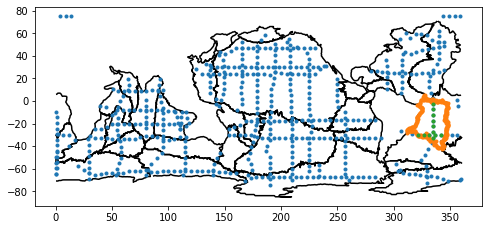

In [30]:
basin = sio.loadmat('../data/bsn_boundary.mat', squeeze_me=True, struct_as_record=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

for i in range(len(basin['bsn_only'])):
    lon = basin['bsn_only'][i].bsn[0].copy()
    lat = basin['bsn_only'][i].bsn[1].copy()
    lon_ = lon.copy()
    lat_ = lat.copy()
    lon__ = lon.copy()
    lat__ = lat.copy()    
    lat[(lon<0) | (lon>360)] = np.nan
    lon[(lon<0) | (lon>360)] = np.nan
    ax.plot(lon,  lat, c='k')
    lat_[lon_>=0] = np.nan
    lon_[lon_>=0] = np.nan
    lon_[lon_<0] += 360
    ax.plot(lon_, lat_, c='k')
    lat__[lon__<=360] = np.nan
    lon__[lon__<=360] = np.nan
    lon__[lon__>=360] -= 360
    ax.plot(lon__, lat__, c='k')
    
ax.plot(var_lon, var_lat, '.')
ax.set_aspect('equal')

k=15
var_mask, var_keys = within_basin(var_lon, var_lat, k)
ax.plot(basin['bsn_only'][k].bsn[0], basin['bsn_only'][k].bsn[1], '.-')
ax.plot(var_lon[var_mask], var_lat[var_mask], '.')


# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
# for i in range(len(basin['bsn_only'])):
#     ax.plot(basin['bsn_only'][i].bsn[0], basin['bsn_only'][i].bsn[1], c='k')

In [41]:
N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[var_mask, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[var_mask, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[var_mask, :])
print(N2_trend_z, z_N2)

[-0.37158898 -0.02758156  0.02015046  0.01134004  0.01159617  0.00166467
  0.00843453  0.00195591 -0.00920543 -0.01737194  0.03169416 -0.02597421
 -0.01710988 -0.02000714 -0.12284023         nan         nan] [   0  400  800 1200 1600 2000 2400 2800 3200 3600 4000 4400 4800 5200
 5600 6000 6400]


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/1690273962.py:1: RuntimeWarning: Mean of empty slice
  N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[var_mask, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[var_mask, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[var_mask, :])


In [65]:
import pandas as pd

Data_trend_BB = xr.open_dataset("/Users/stan/Desktop/WORK/DATA/GOSHIP/EasyOcean/gridded/a16-a23_trend.nc")
N2_z_BB = xr.open_dataset("/Users/stan/Desktop/WORK/DATA/GOSHIP/EasyOcean/gridded/a16-a23_block.nc")
ll=N2_z_BB.LL_st.data
N2_z_BB_ = N2_z_BB.N2_mean.data[:,(ll>=-40) & (ll<=0),:]
var_BB = eval("Data_trend_BB.trend_N2_mean.data")[(ll>=-40) & (ll<=0),:]
var_err_BB = eval("Data_trend_BB.trend_N2_err.data")[(ll>=-40) & (ll<=0),:]
var_eDOF_BB = eval("Data_trend_BB.eDOF.data")[(ll>=-40) & (ll<=0),:]
N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var_BB/np.nanmean(N2_z_BB_, axis=0), var_err_BB/np.nanmean(N2_z_BB_, axis=0), var_eDOF_BB)
print(pd.DataFrame(np.array([N2_trend_z, z_N2]).T, columns=['N2_trend', 'z_N2']))

    N2_trend    z_N2
0  -0.106690     0.0
1   0.007994   400.0
2   0.026525   800.0
3   0.018642  1200.0
4   0.015059  1600.0
5   0.009497  2000.0
6   0.013105  2400.0
7   0.007669  2800.0
8   0.000339  3200.0
9  -0.006200  3600.0
10 -0.007410  4000.0
11 -0.012183  4400.0
12 -0.026852  4800.0
13 -0.020012  5200.0
14  0.561744  5600.0
15 -0.201775  6000.0
16       NaN  6400.0


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_6323/2330450937.py:10: RuntimeWarning: Mean of empty slice
  N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var_BB/np.nanmean(N2_z_BB_, axis=0), var_err_BB/np.nanmean(N2_z_BB_, axis=0), var_eDOF_BB)
